In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
sns.set()

## Load data and transformers back

In [4]:
import pickle
with open('../count-power-transformer.pkl', 'rb') as inf:
    pt = pickle.load(inf)
data = pd.read_pickle('../data-count-transformed.pkl.xz')
print(pt, pt.lambdas_)
data.head()

PowerTransformer(copy=True, method='box-cox', standardize=False) [0.31567024]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_transformed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,4.433145
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,6.982674
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,6.292274
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3.950910
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.000000


In [7]:
data.dtypes

datetime             datetime64[ns]
season                        int64
holiday                       int64
workingday                    int64
weather                       int64
temp                        float64
atemp                       float64
humidity                      int64
windspeed                   float64
casual                        int64
registered                    int64
count                         int64
count_transformed           float64
dtype: object

## Specify features used for training

In [8]:
features = [
    'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
]
target = 'count_transformed'

In [9]:
x = data[features]
y = data[target]

## Split sample data into training set and testing set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_testing, y_train, _, _, y_testing = train_test_split(
    x, y, data['count'],
    test_size=0.25, random_state=42,
)
print(
    'training set:', x_train.shape, y_train.shape,
    '\n',
    'testing set:', x_testing.shape, y_testing.shape,
)

training set: (8164, 8) (8164,) 
 testing set: (2722, 8) (2722,)


## Now import some models

In [12]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [22]:
from sklearn.metrics import mean_squared_log_error
model = RandomForestRegressor(n_estimators=10)
model.fit(x_train, y_train)
pred=model.predict(x_testing)
pred_inversed = pt.inverse_transform(pred.reshape(-1, 1))
np.sqrt(mean_squared_log_error(pred_inversed, y_testing))

1.205079265275069

In [ ]:
from sklearn.metrics import mean_squared_log_error
nq.sqrt(mean_squared_logerror(pred))

In [23]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']

In [24]:
for model in models:
    model.fit(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Compare performance of each model

In [25]:
from sklearn.metrics import mean_squared_log_error

In [26]:
rmsle = []
predictions = []

for name, model in zip(model_names, models):
    y_pred = model.predict(x_testing)
    y_pred = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    predictions.append(y_pred)
    rmsle.append(
        np.sqrt(
            mean_squared_log_error(
                y_pred,
                y_testing,
            )
        )
    )

result = pd.DataFrame({
    'Model': model_names,
    'RMSLE': rmsle,
    'Note': 'first training'
})
result

,Model,RMSLE,Note
0,RandomForestRegressor,1.208769,first training
1,AdaBoostRegressor,1.243089,first training
2,BaggingRegressor,1.212628,first training
3,SVR,1.265796,first training
4,KNeighborsRegressor,1.243948,first training


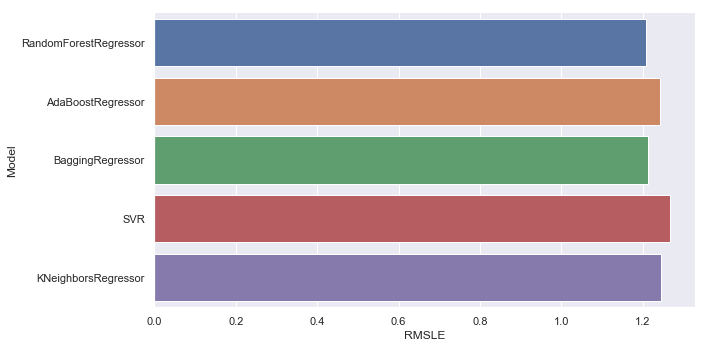

In [27]:
sns.catplot(x='RMSLE', y='Model', data=result, kind='bar', height=5, aspect=2)

In [28]:
testing_output = pd.DataFrame({'testing': y_testing.to_numpy()})
for name, pred in zip(model_names, predictions):
    testing_output[name] = pred
testing_output = testing_output.drop_duplicates().sort_values(by='testing').reset_index(drop=True)
testing_output.head()

,testing,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,SVR,KNeighborsRegressor
0,1,37.116249,82.251773,41.674154,109.409193,63.682169
1,1,22.600706,72.017523,32.972733,87.315963,52.988586
2,1,6.013903,52.151407,6.692933,76.218740,19.593818
3,1,23.831115,52.151407,16.398801,29.960145,16.792310
4,1,13.030462,87.233990,14.533429,20.783680,7.487315


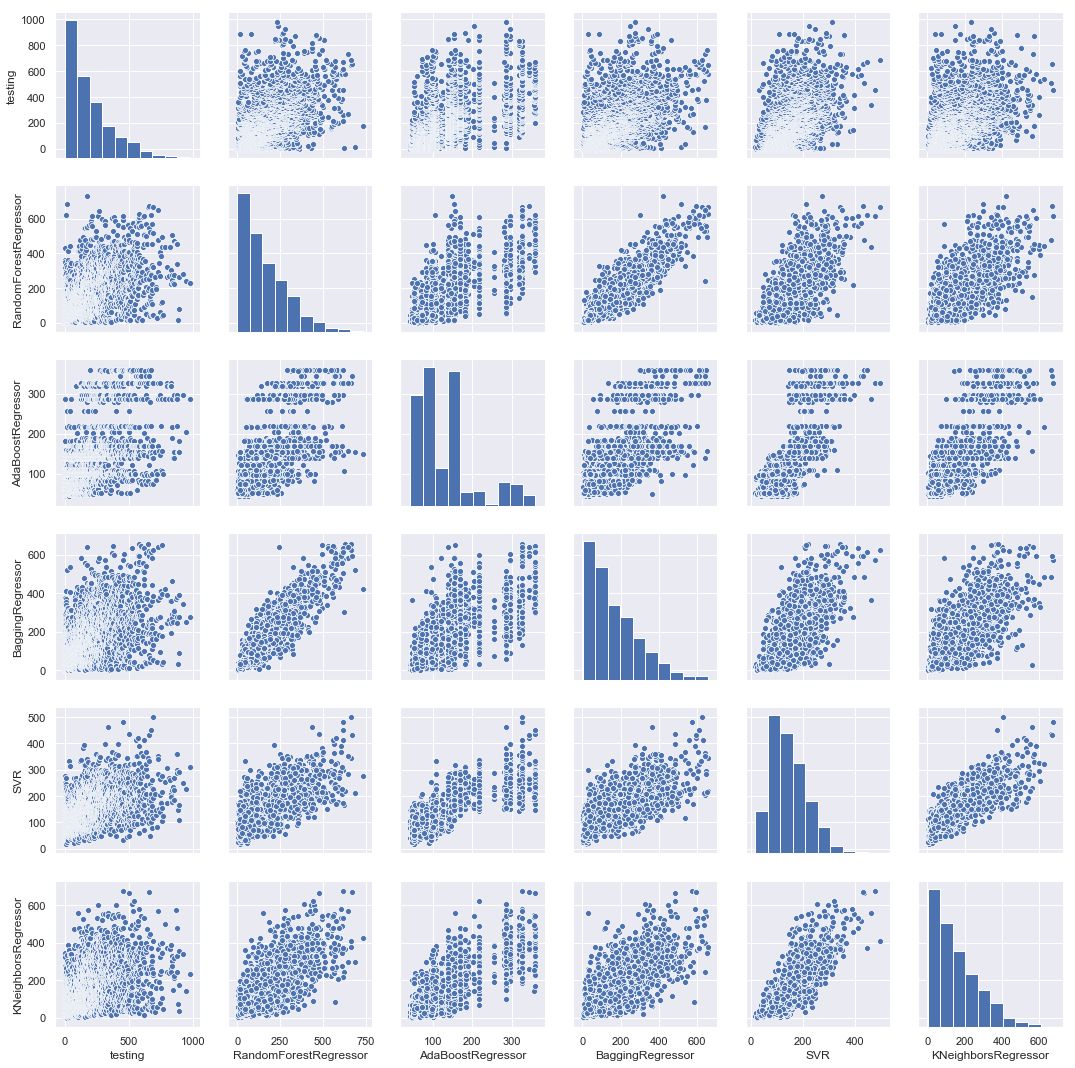

In [29]:
sns.pairplot(
    testing_output,
)

In [17]:
result.to_pickle('../rmsle_first_training.pkl')